To previous notebook: [Network Traffic EDA](./network-traffic-eda.ipynb)<br/>
To the README: [README](./README.md)<br/>

--------------------------------------------------------------------------------

In [1]:
# Import base packages
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from pipe import select, where, sort

import utils.style as style
from utils.confusion import confusion_matrix
from utils.network_traffic import File, Col
from utils.evaluation import evaluate_model, evaluate_hpt, compare_models

# Network Traffic: Machine Learning, Part 2

## Setup: Score and Best Model Tracking

In [2]:
# Fix beta and scorer
from sklearn.metrics import fbeta_score, make_scorer

BETA = 10.0
AVERAGE = 'macro'
scorer = make_scorer(fbeta_score, beta=BETA, average=AVERAGE, zero_division=0.0)

During our tests, we will keep track of the best model and its best score with a simple list and functions to add and extract information in a convenient way:

In [3]:
MODELS = []

def add_model(name, results, on_scaled, on_label_encoded):
    global MODELS
    MODELS.append((results.fbeta, name, results, on_scaled, on_label_encoded))

def add_unscaled_model(name, results, label_encoded): add_model(name, results, False, label_encoded)
def add_scaled_model(name, results, label_encoded): add_model(name, results, True, label_encoded)

def score(record): return record[0]
def name(record): return record[1]
def results(record): return record[2]
def is_trained_on_scaled(record): return record[3]
def is_label_encoded(record): return record[4]
def top(n, on_scaled, label_encoded):
    global MODELS
    return list(
        MODELS | where(lambda model: is_trained_on_scaled(model)==on_scaled and is_label_encoded(model)==label_encoded)
               | sort(key=score, reverse=True)
    )[:n]
    return sorted(MODELS, reverse=True)[:n]
def top_unscaled(n, label_encoded): return top(n, False, label_encoded)
def top_scaled(n, label_encoded): return top(n, True, label_encoded)
def top_overall(n):
    global MODELS
    return list(sorted(MODELS, key=score, reverse=True))[:n]

# To compare different candidates through their tuning stage:
BEST_HPT_RESULT, BEST_HPT_SUB_RESULT = None, None

## Setup: Loading the Training and Verification Data

In [4]:
# Label Encoded Training Data
data_training_label = File.load(File.training_attack_classification_label)
X_training_label = data_training_label.drop(Col.target_classification, axis=1)
y_training = data_training_label[Col.target_classification]

# Label Encoded Verification Data
data_verification_label = File.load(File.verification_attack_classification_label)
X_test_label = data_verification_label.drop(Col.target_classification, axis=1)
y_true = data_verification_label[Col.target_classification]

In [5]:
# One-hot Encoded Training Data
targets_1hot = [Col.target_dos, Col.target_probe, Col.target_r2l, Col.target_u2r]
data_training_1hot = File.load(File.training_attack_classification_1hot)
X_training_1hot = data_training_1hot.drop(targets_1hot, axis=1)

# One-hot Encoded Verification Data
data_verification_1hot = File.load(File.verification_attack_classification_1hot)
X_test_1hot = data_verification_1hot.drop(targets_1hot, axis=1)

This time, we will not look into the models' performance on the scaled datasets; the impact is not as significant as other preprocessing methods we will discuss later, at least at that point.

In [6]:
features_label = Col.above(0.2, target_identification=False, label_encoded=True)['Feature']
features_label

0     % of same-host connections from destination to...
1     #Connections to same host from destination in ...
2        % of same-host connections to the same service
3     % of same-host connections from destination to...
4     % of same-service connections from destination...
5     % of same-host connections from destination to...
6      % of same-service connections to different hosts
7          % of same-host connections with `SYN` errors
8      % of same-host connections to different services
9                          Logged in? (0 - No, 1 - Yes)
10       Login belongs to guest list? (0 - No, 1 - Yes)
11                                      #Hot indicators
12                                                 Flag
13                 #Connections to same host in past 2s
14                                         Duration (s)
Name: Feature, dtype: object

In [7]:
features_1hot_dos   = Col.above(0.2, target_identification=False, label_encoded=False, one_hot_target='dos')['Feature']
features_1hot_probe = Col.above(0.2, target_identification=False, label_encoded=False, one_hot_target='probe')['Feature']
features_1hot_r2l   = Col.above(0.2, target_identification=False, label_encoded=False, one_hot_target='r2l')['Feature']
features_1hot_u2r   = Col.above(0.2, target_identification=False, label_encoded=False, one_hot_target='u2r')['Feature']

# Combine them into one selection using sets:
features_1hot = list(set(features_1hot_dos).union(features_1hot_probe).union(features_1hot_r2l).union(features_1hot_u2r))
features_1hot

['% of same-host connections from destination to the same service',
 '#Hot indicators',
 '% of same-host connections to different services',
 '% of same-host connections from destination to different services',
 'Protocol Type_icmp',
 '% of same-host connections to the same service',
 'Protocol Type_udp',
 '% of same-host connections from destination to the same service and port',
 'Service_other',
 'Flag_RSTR',
 'Service_eco_i',
 '% of same-service connections to different hosts',
 'Service_ftp',
 'Logged in? (0 - No, 1 - Yes)',
 'Duration (s)',
 '#Shell prompts',
 'Is root shell obtained? (0 - No, 1 - Yes)',
 '#Connections to same host from destination in past 2s',
 'Flag_SF',
 'Protocol Type_tcp',
 '% of same-host connections with `SYN` errors',
 'Login belongs to guest list? (0 - No, 1 - Yes)',
 '#Connections to same host in past 2s',
 'Service_ftp_data',
 '% of same-service connections from destination to different hosts']

In [8]:
# Create training and verification subsets with those selected features

X_training_label_sub = data_training_label[features_label].copy()
X_test_label_sub = data_verification_label[features_label].copy()

X_training_1hot_sub = data_training_1hot[features_1hot].copy()
X_test_1hot_sub = data_verification_1hot[features_1hot].copy()

Finally we want to suppress convergence wanrings for models that fail to converge within the set limits for iterations.

In [76]:
import os
import warnings

if not os.sys.warnoptions:
    warnings.simplefilter('ignore')
    #os.environ['PYTHONWARNINGS'] = 'ignore::ConvergenceWarning:sklearn.model_selection.GridSearchCV,ignore::ConvergenceWarning:sklearn.model_selection.RandomizedSearchCV'
    os.environ['PYTHONWARNINGS'] = 'ignore'

--------------------------------------------------------------------------------

## Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
random_forest = RandomForestClassifier(n_jobs=-1, random_state=404)     # base estimator
rf_param_grid = {                                                       # parameter grid for hyperparameter tuning
    'n_estimators': [5, 10, 20, 100, 150],
    'max_depth':    [5, 10, 20, 40, 60, None],
    'criterion':    ['gini', 'entropy', 'log_loss'],
}

In [12]:
rf_model_label = GridSearchCV(
    estimator=random_forest,
    param_grid=rf_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
rf_model_1hot = GridSearchCV(
    estimator=random_forest,
    param_grid=rf_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)

In [16]:
%time _ = rf_model_label.fit(X_training_label_sub, y_training)

CPU times: user 28min 23s, sys: 1min 49s, total: 30min 13s
Wall time: 5min 46s


In [17]:
%time _ = rf_model_1hot.fit(X_training_1hot_sub, y_training)

CPU times: user 33min 20s, sys: 1min 53s, total: 35min 14s
Wall time: 6min 32s


-- Training Results --
Best Parameters:
	criterion:	entropy
	max_depth:	40
	n_estimators:	5
Best Score:
	0.827830

-- Testing Results --
Accuracy    on Verification Data:	0.891517
Fbeta scroe on Verification Data:	0.594189

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     23747
           1       0.65      0.73      0.69      3041
           2       0.72      0.49      0.59      2533
           3       0.23      0.19      0.21        57

    accuracy                           0.89     29378
   macro avg       0.64      0.59      0.61     29378
weighted avg       0.89      0.89      0.89     29378



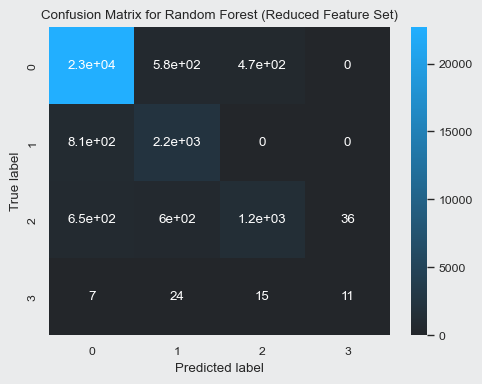

In [18]:
# Evaluate the process
rf_hpt_label_result = evaluate_hpt(
    model=rf_model_label,
    X_test=X_test_label_sub,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, rf_hpt_label_result.predictions, 'Random Forest (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	criterion:	entropy
	max_depth:	20
	n_estimators:	150
Best Score:
	0.865996

-- Testing Results --
Accuracy    on Verification Data:	0.908639
Fbeta scroe on Verification Data:	0.637194

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     23747
           1       0.69      0.75      0.72      3041
           2       0.79      0.60      0.68      2533
           3       0.30      0.23      0.26        57

    accuracy                           0.91     29378
   macro avg       0.68      0.64      0.65     29378
weighted avg       0.91      0.91      0.91     29378



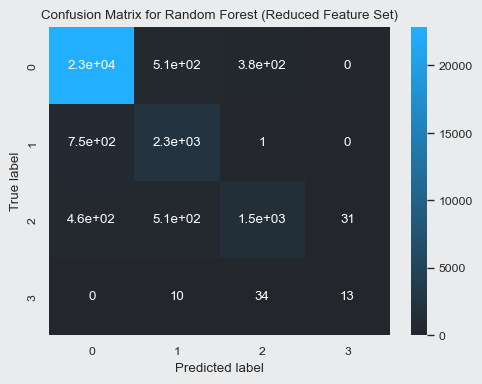

In [19]:
# Evaluate the process
rf_hpt_1hot_result = evaluate_hpt(
    model=rf_model_1hot,
    X_test=X_test_1hot_sub,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, rf_hpt_1hot_result.predictions, 'Random Forest (Reduced Feature Set)')

Next, let's let the best candidate of this process train on the full featureset.

In [20]:
best_random_forest_label = rf_model_label.best_estimator_
best_random_forest_1hot = rf_model_1hot.best_estimator_

In [21]:
%time _ = best_random_forest_label.fit(X_training_label, y_training)

CPU times: user 719 ms, sys: 65.9 ms, total: 785 ms
Wall time: 179 ms


In [22]:
%time _ = best_random_forest_1hot.fit(X_training_1hot, y_training)

CPU times: user 15.8 s, sys: 858 ms, total: 16.6 s
Wall time: 2.89 s



-- Testing Results --
Accuracy    on Verification Data:	0.901457
Fbeta scroe on Verification Data:	0.663951

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     23747
           1       0.53      0.90      0.67      3041
           2       0.94      0.59      0.72      2533
           3       0.26      0.23      0.24        57

    accuracy                           0.90     29378
   macro avg       0.68      0.66      0.65     29378
weighted avg       0.93      0.90      0.91     29378



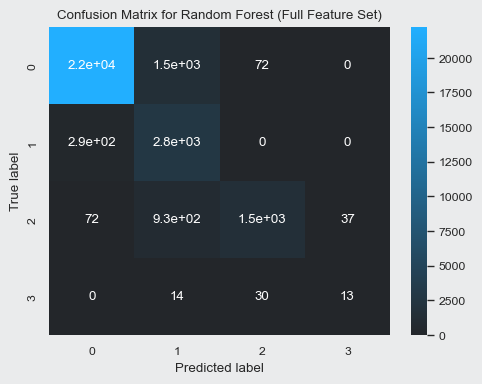

In [23]:
# Evaluate this model
rf_model_label_result = evaluate_model(
    model=best_random_forest_label,
    X_test=X_test_label,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, rf_model_label_result.predictions, "Random Forest (Full Feature Set)")

In [24]:
# Compare with respective prototype model
_ = compare_models(rf_model_label_result, rf_hpt_label_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.069763 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.009939 --> Improvement!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=40, n_estimators=5,
                       n_jobs=-1, random_state=404)
Its score: 0.663951



-- Testing Results --
Accuracy    on Verification Data:	0.902240
Fbeta scroe on Verification Data:	0.685729

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     23747
           1       0.53      0.93      0.67      3041
           2       0.95      0.47      0.63      2533
           3       0.39      0.40      0.40        57

    accuracy                           0.90     29378
   macro avg       0.71      0.69      0.67     29378
weighted avg       0.94      0.90      0.91     29378



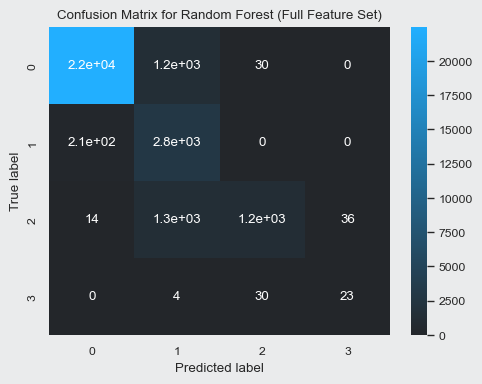

In [25]:
# Evaluate this model
rf_model_1hot_result = evaluate_model(
    model=best_random_forest_1hot,
    X_test=X_test_1hot,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, rf_model_1hot_result.predictions, "Random Forest (Full Feature Set)")

In [26]:
# Compare with respective prototype model
_ = compare_models(rf_model_1hot_result, rf_hpt_1hot_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.048535 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.006399 --> Worsened!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404)
Its score: 0.685729


In [47]:
# Compare prototype models with each other
print('\tRandom Forest: Label Encoded VS One-hot Encoded')
BEST_HPT_SUB_RESULT = compare_models(rf_hpt_label_result, rf_hpt_1hot_result)

	Random Forest: Label Encoded VS One-hot Encoded
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.043005 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.017122 --> Worsened!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404) with Parameters
{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 150}
Its score: 0.637194


In [28]:
# Compare full models with each other
print('\tRandom Forest: Label Encoded VS One-hot Encoded (Full Featureset)')
BEST_HPT_RESULT = compare_models(rf_model_label_result, rf_model_1hot_result)

	Random Forest: Label Encoded VS One-hot Encoded (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.021778 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.000783 --> Worsened!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404)
Its score: 0.685729


In [29]:
# Store the model results
add_unscaled_model('Random Forest', rf_model_label_result, label_encoded=True)
add_unscaled_model('Random Forest', rf_model_1hot_result, label_encoded=False)

--------------------------------------------------------------------------------

## K Nearest Neighbors

Our next candidate is KNN.
This model significantly benefits from our undersampling approach, as its computation time drastically increases with the data complexity.
The process we follow is the exact same as for the random forest approach:

In [30]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
knn = KNeighborsClassifier(n_jobs=-1)                                   # base estimator
knn_param_grid = {                                                      # parameter grid for hyperparameter tuning
    'n_neighbors':  [5, 10, 20, 100, 150],
    'weights':      ['uniform', 'distance'],
}

In [32]:
knn_model_label = GridSearchCV(
    estimator=knn,
    param_grid=knn_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
knn_model_1hot = GridSearchCV(
    estimator=knn,
    param_grid=knn_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)

In [33]:
%time _ = knn_model_label.fit(X_training_label_sub, y_training)

CPU times: user 6min 11s, sys: 3.62 s, total: 6min 14s
Wall time: 1min 23s


In [34]:
%time _ = knn_model_1hot.fit(X_training_1hot_sub, y_training)

CPU times: user 1h 6min 3s, sys: 43.5 s, total: 1h 6min 47s
Wall time: 9min 20s


-- Training Results --
Best Parameters:
	n_neighbors:	5
	weights:	distance
Best Score:
	0.756066

-- Testing Results --
Accuracy    on Verification Data:	0.852407
Fbeta scroe on Verification Data:	0.515607

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     23747
           1       0.44      0.79      0.56      3041
           2       0.74      0.23      0.36      2533
           3       0.02      0.12      0.03        57

    accuracy                           0.85     29378
   macro avg       0.54      0.52      0.48     29378
weighted avg       0.89      0.85      0.86     29378



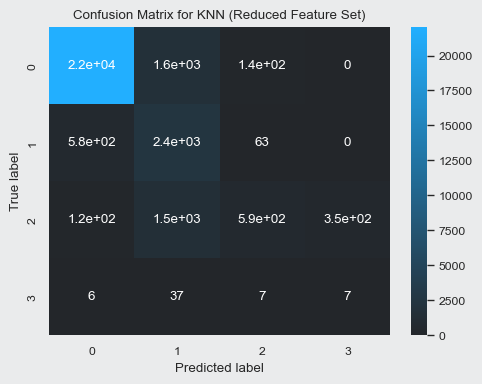

In [35]:
# Evaluate the process
knn_hpt_label_result = evaluate_hpt(
    model=knn_model_label,
    X_test=X_test_label_sub,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, knn_hpt_label_result.predictions, 'KNN (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	n_neighbors:	5
	weights:	distance
Best Score:
	0.814798

-- Testing Results --
Accuracy    on Verification Data:	0.863197
Fbeta scroe on Verification Data:	0.522067

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     23747
           1       0.45      0.79      0.57      3041
           2       0.96      0.25      0.39      2533
           3       0.02      0.12      0.03        57

    accuracy                           0.86     29378
   macro avg       0.60      0.52      0.49     29378
weighted avg       0.91      0.86      0.86     29378



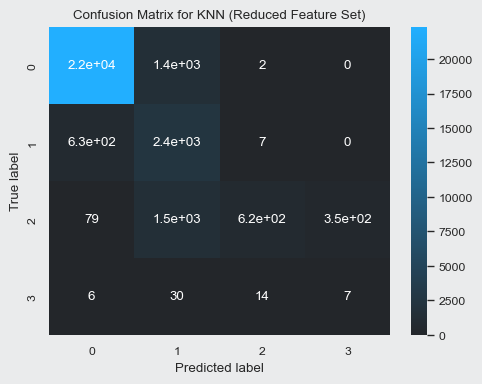

In [36]:
# Evaluate the process
knn_hpt_1hot_result = evaluate_hpt(
    model=knn_model_1hot,
    X_test=X_test_1hot_sub,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, knn_hpt_1hot_result.predictions, 'KNN (Reduced Feature Set)')

Next, let's let the best candidate of this process train on the full featureset.

In [37]:
best_knn_label = knn_model_label.best_estimator_
best_knn_1hot = knn_model_1hot.best_estimator_

In [38]:
%time _ = best_knn_label.fit(X_training_label, y_training)

CPU times: user 262 ms, sys: 65.3 ms, total: 328 ms
Wall time: 119 ms


In [39]:
%time _ = best_knn_1hot.fit(X_training_1hot, y_training)

CPU times: user 131 ms, sys: 137 ms, total: 268 ms
Wall time: 298 ms



-- Testing Results --
Accuracy    on Verification Data:	0.848152
Fbeta scroe on Verification Data:	0.593187

              precision    recall  f1-score   support

           0       0.95      0.94      0.94     23747
           1       0.42      0.71      0.53      3041
           2       0.90      0.20      0.33      2533
           3       0.16      0.54      0.25        57

    accuracy                           0.85     29378
   macro avg       0.61      0.60      0.51     29378
weighted avg       0.89      0.85      0.84     29378



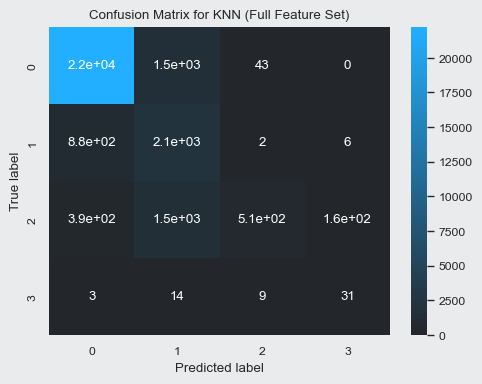

In [40]:
# Evaluate this model
knn_model_label_result = evaluate_model(
    model=best_knn_label,
    X_test=X_test_label,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, knn_model_label_result.predictions, "KNN (Full Feature Set)")

In [41]:
# Compare with respective prototype model
_ = compare_models(knn_model_label_result, knn_hpt_label_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.077579 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.004255 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.593187



-- Testing Results --
Accuracy    on Verification Data:	0.852475
Fbeta scroe on Verification Data:	0.602355

              precision    recall  f1-score   support

           0       0.95      0.94      0.94     23747
           1       0.43      0.74      0.55      3041
           2       0.90      0.20      0.33      2533
           3       0.16      0.54      0.25        57

    accuracy                           0.85     29378
   macro avg       0.61      0.61      0.52     29378
weighted avg       0.89      0.85      0.85     29378



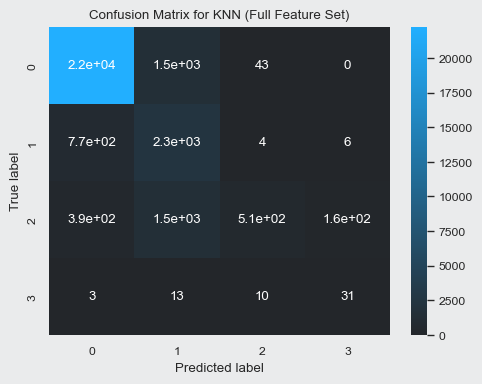

In [42]:
# Evaluate this model
knn_model_1hot_result = evaluate_model(
    model=best_knn_1hot,
    X_test=X_test_1hot,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, knn_model_1hot_result.predictions, "KNN (Full Feature Set)")

In [43]:
# Compare with respective prototype model
_ = compare_models(knn_model_1hot_result, knn_hpt_1hot_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.080288 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.010722 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.602355


In [44]:
# Compare prototype models with each other
print('\tKNN: Label Encoded VS One-hot Encoded')
_ = compare_models(knn_hpt_label_result, knn_hpt_1hot_result)

	KNN: Label Encoded VS One-hot Encoded
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.006460 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.010790 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance') with Parameters
{'n_neighbors': 5, 'weights': 'distance'}
Its score: 0.522067


In [45]:
# Compare full models with each other
print('\tKNN: Label Encoded VS One-hot Encoded (Full Featureset)')
_ = compare_models(knn_model_label_result, knn_model_1hot_result)

	KNN: Label Encoded VS One-hot Encoded (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.009169 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.004323 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.602355


In [48]:
# Compare with previous HPT results
BEST_HPT_SUB_RESULT = compare_models(knn_hpt_label_result, BEST_HPT_SUB_RESULT)
print()
BEST_HPT_SUB_RESULT = compare_models(knn_hpt_1hot_result, BEST_HPT_SUB_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.121587 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.056233 --> Worsened!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404) with Parameters
{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 150}
Its score: 0.637194

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.115127 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.045442 --> Worsened!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404) with Parameters
{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 150}
Its score: 0.637194


In [49]:
# Track overall best model
_ = compare_models(knn_model_label_result, results(top_overall(1)[0]))
print()
_ = compare_models(knn_model_1hot_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.092542 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.054088 --> Worsened!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404)
Its score: 0.685729

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.083374 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.049765 --> Worsened!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404)
Its score: 0.685729


In [50]:
# Store the model results
add_unscaled_model('KNN', knn_model_label_result, label_encoded=True)
add_unscaled_model('KNN', knn_model_1hot_result, label_encoded=False)

--------------------------------------------------------------------------------

## Naive Bayes

Our next candidate is Naive Bayes.
Now this model doesn't offer much in terms of hyperparameter tuning, but we want to include it anyways.

Again, the same procedure as before...

In [51]:
from sklearn.naive_bayes import ComplementNB

In [52]:
naive_bayes = ComplementNB()
nb_param_grid = {                                                      # parameter grid for hyperparameter tuning
    'alpha': [.5 + .2*n for n in range(10)],
}

In [53]:
nb_model_label = GridSearchCV(
    estimator=naive_bayes,
    param_grid=nb_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
nb_model_1hot = GridSearchCV(
    estimator=naive_bayes,
    param_grid=nb_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)

In [54]:
%time _ = nb_model_label.fit(X_training_label_sub, y_training)

CPU times: user 22.1 s, sys: 693 ms, total: 22.8 s
Wall time: 3.43 s


In [55]:
%time _ = nb_model_1hot.fit(X_training_1hot_sub, y_training)

CPU times: user 31.4 s, sys: 1.9 s, total: 33.3 s
Wall time: 5.23 s


-- Training Results --
Best Parameters:
	alpha:	0.5
Best Score:
	0.293581

-- Testing Results --
Accuracy    on Verification Data:	0.773504
Fbeta scroe on Verification Data:	0.239360

              precision    recall  f1-score   support

           0       0.83      0.96      0.89     23747
           1       0.00      0.00      0.00      3041
           2       0.00      0.00      0.00      2533
           3       0.00      0.00      0.00        57

    accuracy                           0.77     29378
   macro avg       0.21      0.24      0.22     29378
weighted avg       0.67      0.77      0.72     29378



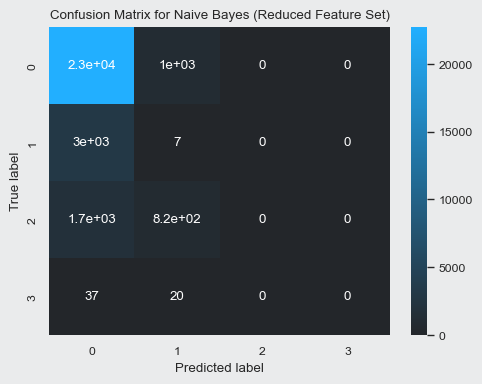

In [56]:
# Evaluate the process
nb_hpt_label_result = evaluate_hpt(
    model=nb_model_label,
    X_test=X_test_label_sub,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, nb_hpt_label_result.predictions, 'Naive Bayes (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	alpha:	0.5
Best Score:
	0.362065

-- Testing Results --
Accuracy    on Verification Data:	0.780686
Fbeta scroe on Verification Data:	0.259662

              precision    recall  f1-score   support

           0       0.83      0.95      0.89     23747
           1       0.12      0.08      0.10      3041
           2       0.00      0.00      0.00      2533
           3       0.00      0.00      0.00        57

    accuracy                           0.78     29378
   macro avg       0.24      0.26      0.25     29378
weighted avg       0.69      0.78      0.73     29378



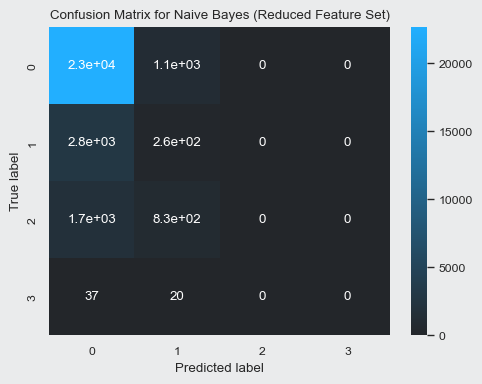

In [57]:
# Evaluate the process
nb_hpt_1hot_result = evaluate_hpt(
    model=nb_model_1hot,
    X_test=X_test_1hot_sub,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, nb_hpt_1hot_result.predictions, 'Naive Bayes (Reduced Feature Set)')

Next, let's let the best candidate of this process train on the full featureset.

In [58]:
best_nb_label = nb_model_label.best_estimator_
best_nb_1hot = nb_model_1hot.best_estimator_

In [59]:
%time _ = best_nb_label.fit(X_training_label, y_training)

CPU times: user 755 ms, sys: 44.6 ms, total: 800 ms
Wall time: 203 ms


In [60]:
%time _ = best_nb_1hot.fit(X_training_1hot, y_training)

CPU times: user 1.6 s, sys: 222 ms, total: 1.82 s
Wall time: 284 ms



-- Testing Results --
Accuracy    on Verification Data:	0.761624
Fbeta scroe on Verification Data:	0.235252

              precision    recall  f1-score   support

           0       0.81      0.94      0.87     23747
           1       0.00      0.00      0.00      3041
           2       0.00      0.00      0.00      2533
           3       0.00      0.00      0.00        57

    accuracy                           0.76     29378
   macro avg       0.20      0.24      0.22     29378
weighted avg       0.66      0.76      0.70     29378



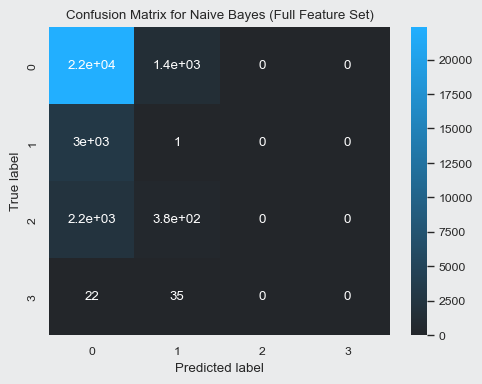

In [61]:
# Evaluate this model
nb_model_label_result = evaluate_model(
    model=best_nb_label,
    X_test=X_test_label,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, nb_model_label_result.predictions, "Naive Bayes (Full Feature Set)")

In [62]:
# Compare with respective prototype model
_ = compare_models(nb_model_label_result, nb_hpt_label_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.004108 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.011880 --> Worsened!

Best model so far:
ComplementNB(alpha=0.5)
Its score: 0.239360



-- Testing Results --
Accuracy    on Verification Data:	0.761420
Fbeta scroe on Verification Data:	0.235336

              precision    recall  f1-score   support

           0       0.81      0.94      0.87     23747
           1       0.00      0.00      0.00      3041
           2       0.00      0.00      0.00      2533
           3       0.00      0.00      0.00        57

    accuracy                           0.76     29378
   macro avg       0.20      0.24      0.22     29378
weighted avg       0.66      0.76      0.70     29378



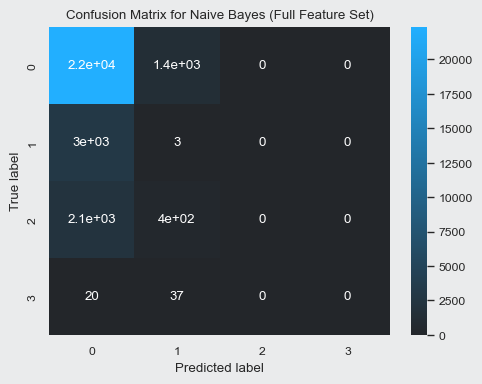

In [63]:
# Evaluate this model
nb_model_1hot_result = evaluate_model(
    model=best_nb_1hot,
    X_test=X_test_1hot,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, nb_model_1hot_result.predictions, "Naive Bayes (Full Feature Set)")

In [64]:
# Compare with respective prototype model
_ = compare_models(nb_model_1hot_result, nb_hpt_1hot_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.024326 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.019266 --> Worsened!

Best model so far:
ComplementNB(alpha=0.5)
Its score: 0.259662


In [65]:
# Compare HPT results with each other
print('\tNaive Bayes: Label Encoded VS One-hot Encoded')
_ = compare_models(nb_hpt_label_result, nb_hpt_1hot_result)

	Naive Bayes: Label Encoded VS One-hot Encoded
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.020302 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.007182 --> Worsened!

Best model so far:
ComplementNB(alpha=0.5) with Parameters
{'alpha': 0.5}
Its score: 0.259662


In [66]:
# Compare full models with each other
print('\tNaive Bayes: Label Encoded VS One-hot Encoded (Full Featureset)')
_ = compare_models(nb_model_label_result, nb_model_1hot_result)

	Naive Bayes: Label Encoded VS One-hot Encoded (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.000084 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000204 --> Improvement!

Best model so far:
ComplementNB(alpha=0.5)
Its score: 0.235336


In [67]:
# Compare with previous HPT results
BEST_HPT_SUB_RESULT = compare_models(nb_hpt_label_result, BEST_HPT_SUB_RESULT)
print()
BEST_HPT_SUB_RESULT = compare_models(nb_hpt_1hot_result, BEST_HPT_SUB_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.397834 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.135135 --> Worsened!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404) with Parameters
{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 150}
Its score: 0.637194

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.377532 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.127953 --> Worsened!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404) with Parameters
{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 150}
Its score: 0.637194


In [68]:
# Track overall best model
_ = compare_models(nb_model_label_result, results(top_overall(1)[0]))
print()
_ = compare_models(nb_model_1hot_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.450477 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.140615 --> Worsened!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404)
Its score: 0.685729

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.450393 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.140820 --> Worsened!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404)
Its score: 0.685729


In [69]:
# Store the model results (although this one won't appear in our final selection)
add_unscaled_model('Naive Bayes', nb_model_label_result, label_encoded=True)
add_unscaled_model('Naive Bayes', nb_model_1hot_result, label_encoded=False)

--------------------------------------------------------------------------------

## Logistic Regression

In [70]:
from sklearn.linear_model import LogisticRegression

In [71]:
logistic_regression = LogisticRegression(max_iter=15_000, n_jobs=-1, random_state=404)  # base estimator
lr_param_grid = {                                                                       # parameter grid for hyperparameter tuning
    'tol': [1.e-3, 1.e-4, 1.e-5],
    'C': [.4+.1*n for n in range(12)],
    'fit_intercept': [True, False],
}

In [72]:
lr_model_label = RandomizedSearchCV(
    estimator=logistic_regression,
    param_distributions=lr_param_grid,
    refit=True,
    verbose=0,
    n_jobs=-1,
    scoring=scorer,
    n_iter=15,
    random_state=404
)
lr_model_1hot = RandomizedSearchCV(
    estimator=logistic_regression,
    param_distributions=lr_param_grid,
    refit=True,
    verbose=0,
    n_jobs=-1,
    scoring=scorer,
    n_iter=15,
    random_state=404
)

In [77]:
%time _ = lr_model_label.fit(X_training_label_sub, y_training)

CPU times: user 2.57 s, sys: 1.42 s, total: 3.99 s
Wall time: 26min 56s


In [78]:
%time _ = lr_model_1hot.fit(X_training_1hot_sub, y_training)

CPU times: user 2.6 s, sys: 1.43 s, total: 4.03 s
Wall time: 30min 8s


-- Training Results --
Best Parameters:
	tol:	0.0001
	fit_intercept:	False
	C:	0.7000000000000001
Best Score:
	0.710812

-- Testing Results --
Accuracy    on Verification Data:	0.865341
Fbeta scroe on Verification Data:	0.483408

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     23747
           1       0.74      0.73      0.73      3041
           2       0.50      0.22      0.30      2533
           3       0.01      0.04      0.01        57

    accuracy                           0.87     29378
   macro avg       0.54      0.48      0.49     29378
weighted avg       0.85      0.87      0.85     29378



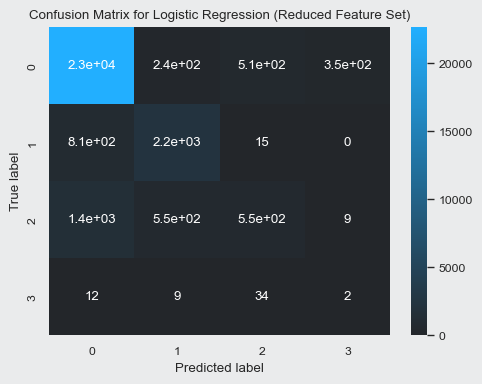

In [79]:
# Evaluate the process
lr_hpt_label_result = evaluate_hpt(
    model=lr_model_label,
    X_test=X_test_label_sub,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, lr_hpt_label_result.predictions, 'Logistic Regression (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	tol:	1e-05
	fit_intercept:	True
	C:	1.4
Best Score:
	0.790256

-- Testing Results --
Accuracy    on Verification Data:	0.880693
Fbeta scroe on Verification Data:	0.613587

              precision    recall  f1-score   support

           0       0.91      0.96      0.93     23747
           1       0.87      0.63      0.73      3041
           2       0.71      0.48      0.58      2533
           3       0.06      0.40      0.10        57

    accuracy                           0.88     29378
   macro avg       0.63      0.62      0.58     29378
weighted avg       0.88      0.88      0.88     29378



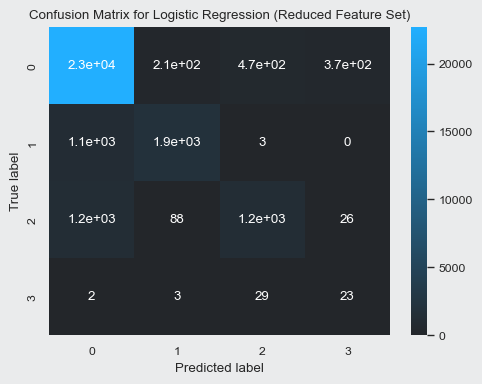

In [80]:
# Evaluate the process
lr_hpt_1hot_result = evaluate_hpt(
    model=lr_model_1hot,
    X_test=X_test_1hot_sub,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, lr_hpt_1hot_result.predictions, 'Logistic Regression (Reduced Feature Set)')

Next, let's let the best candidate of this process train on the full featureset.

In [81]:
best_lr_label = lr_model_label.best_estimator_
best_lr_1hot = lr_model_1hot.best_estimator_

In [82]:
%time _ = best_lr_label.fit(X_training_label, y_training)

CPU times: user 626 ms, sys: 261 ms, total: 887 ms
Wall time: 4min 17s


In [83]:
%time _ = best_lr_1hot.fit(X_training_1hot, y_training)

CPU times: user 588 ms, sys: 401 ms, total: 989 ms
Wall time: 9min 48s



-- Testing Results --
Accuracy    on Verification Data:	0.786609
Fbeta scroe on Verification Data:	0.286424

              precision    recall  f1-score   support

           0       0.85      0.95      0.90     23747
           1       0.21      0.20      0.20      3041
           2       1.00      0.00      0.00      2533
           3       0.00      0.00      0.00        57

    accuracy                           0.79     29378
   macro avg       0.51      0.29      0.28     29378
weighted avg       0.79      0.79      0.75     29378



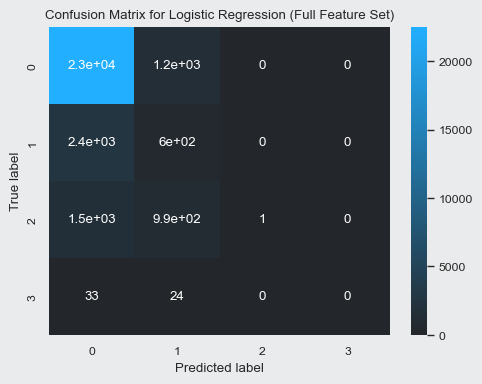

In [84]:
# Evaluate this model
lr_model_label_result = evaluate_model(
    model=best_lr_label,
    X_test=X_test_label,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, lr_model_label_result.predictions, "Logistic Regression (Full Feature Set)")

In [85]:
# Compare with respective prototype model
_ = compare_models(lr_model_label_result, lr_hpt_label_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.196984 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.078732 --> Worsened!

Best model so far:
LogisticRegression(C=0.7000000000000001, fit_intercept=False, max_iter=15000,
                   n_jobs=-1, random_state=404)
Its score: 0.483408



-- Testing Results --
Accuracy    on Verification Data:	0.773368
Fbeta scroe on Verification Data:	0.292529

              precision    recall  f1-score   support

           0       0.87      0.93      0.89     23747
           1       0.19      0.25      0.21      3041
           2       0.00      0.00      0.00      2533
           3       0.00      0.00      0.00        57

    accuracy                           0.77     29378
   macro avg       0.26      0.29      0.28     29378
weighted avg       0.72      0.77      0.75     29378



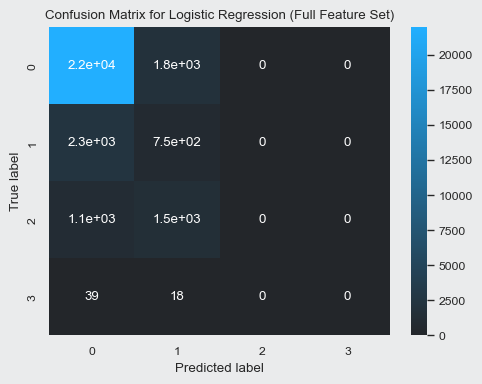

In [86]:
# Evaluate this model
lr_model_1hot_result = evaluate_model(
    model=best_lr_1hot,
    X_test=X_test_1hot,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, lr_model_1hot_result.predictions, "Logistic Regression (Full Feature Set)")

In [87]:
# Compare with respective prototype model
_ = compare_models(lr_model_1hot_result, lr_hpt_1hot_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.321058 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.107325 --> Worsened!

Best model so far:
LogisticRegression(C=1.4, max_iter=15000, n_jobs=-1, random_state=404,
                   tol=1e-05)
Its score: 0.613587


In [88]:
# Compare prototype models with each other
print('\tLogistic Regression: Label Encoded VS One-hot Encoded')
_ = compare_models(lr_hpt_label_result, lr_hpt_1hot_result)

	Logistic Regression: Label Encoded VS One-hot Encoded
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.130179 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.015352 --> Worsened!

Best model so far:
LogisticRegression(C=1.4, max_iter=15000, n_jobs=-1, random_state=404,
                   tol=1e-05) with Parameters
{'tol': 1e-05, 'fit_intercept': True, 'C': 1.4}
Its score: 0.613587


In [89]:
# Compare full models with each other
print('\tLogistic Regression: Label Encoded VS One-hot Encoded (Full Featureset)')
_ = compare_models(lr_model_label_result, lr_model_1hot_result)

	Logistic Regression: Label Encoded VS One-hot Encoded (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.006105 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.013241 --> Improvement!

Best model so far:
LogisticRegression(C=1.4, max_iter=15000, n_jobs=-1, random_state=404,
                   tol=1e-05)
Its score: 0.292529


In [90]:
# Compare with previous HPT results
BEST_HPT_SUB_RESULT = compare_models(lr_hpt_label_result, BEST_HPT_SUB_RESULT)
print()
BEST_HPT_SUB_RESULT = compare_models(lr_hpt_1hot_result, BEST_HPT_SUB_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.153786 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.043298 --> Worsened!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404) with Parameters
{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 150}
Its score: 0.637194

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.023607 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.027946 --> Worsened!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404) with Parameters
{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 150}
Its score: 0.637194


In [91]:
# Track overall best model
_ = compare_models(lr_model_label_result, results(top_overall(1)[0]))
print()
_ = compare_models(lr_model_1hot_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.399304 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.115631 --> Worsened!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404)
Its score: 0.685729

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.393200 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.128872 --> Worsened!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404)
Its score: 0.685729


In [92]:
# Store the model results
add_unscaled_model('Logistic Regression', lr_model_label_result, label_encoded=True)
add_unscaled_model('Logistic Regression', lr_model_1hot_result, label_encoded=False)

--------------------------------------------------------------------------------

## Support Vector Machine

In [93]:
from sklearn.svm import SVC

In [94]:
svc = SVC(max_iter=15000, random_state=404)                                             # base estimator
svc_param_grid = {                                                                      # parameter grid for hyperparameter tuning
    'C': [.4+.2*n for n in range(6)],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3, 5, 10, 15],
    'tol': [1.e-4, 1.e-5, 1.e-6],
}

In [95]:
svc_model_label = RandomizedSearchCV(
    estimator=svc,
    param_distributions=svc_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer,
    n_jobs=-1,
    n_iter=15,
    random_state=404
)
svc_model_1hot = RandomizedSearchCV(
    estimator=svc,
    param_distributions=svc_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer,
    n_jobs=-1,
    n_iter=15,
    random_state=404
)

In [96]:
%time _ = svc_model_label.fit(X_training_label_sub, y_training)

CPU times: user 18.4 s, sys: 2.64 s, total: 21.1 s
Wall time: 1h 19min 2s


In [97]:
%time _ = svc_model_1hot.fit(X_training_1hot_sub, y_training)

CPU times: user 20.1 s, sys: 3.92 s, total: 24 s
Wall time: 1h 11min 1s


-- Training Results --
Best Parameters:
	tol:	1e-06
	kernel:	linear
	degree:	10
	C:	0.4
Best Score:
	0.500855

-- Testing Results --
Accuracy    on Verification Data:	0.846688
Fbeta scroe on Verification Data:	0.437669

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     23747
           1       0.56      0.50      0.53      3041
           2       0.85      0.30      0.44      2533
           3       0.00      0.00      0.00        57

    accuracy                           0.85     29378
   macro avg       0.57      0.44      0.47     29378
weighted avg       0.85      0.85      0.84     29378



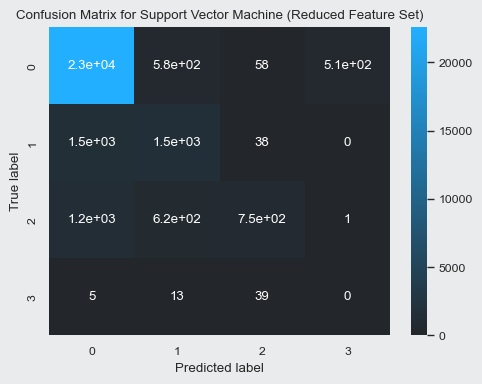

In [98]:
# Evaluate the process
svc_hpt_label_result = evaluate_hpt(
    model=svc_model_label,
    X_test=X_test_label_sub,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, svc_hpt_label_result.predictions, 'Support Vector Machine (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	tol:	0.0001
	kernel:	linear
	degree:	3
	C:	1.4
Best Score:
	0.655451

-- Testing Results --
Accuracy    on Verification Data:	0.213629
Fbeta scroe on Verification Data:	0.241493

              precision    recall  f1-score   support

           0       0.57      0.17      0.26     23747
           1       0.06      0.46      0.11      3041
           2       0.98      0.37      0.53      2533
           3       0.00      0.00      0.00        57

    accuracy                           0.21     29378
   macro avg       0.41      0.25      0.23     29378
weighted avg       0.55      0.21      0.27     29378



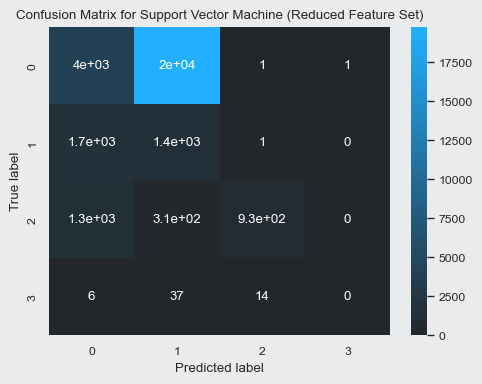

In [99]:
# Evaluate the process
svc_hpt_1hot_result = evaluate_hpt(
    model=svc_model_1hot,
    X_test=X_test_1hot_sub,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, svc_hpt_1hot_result.predictions, 'Support Vector Machine (Reduced Feature Set)')

Next, let's let the best candidate of this process train on the full featureset.

In [100]:
best_svc_label = svc_model_label.best_estimator_
best_svc_1hot = svc_model_1hot.best_estimator_

In [101]:
%time _ = best_svc_label.fit(X_training_label, y_training)

CPU times: user 14.5 s, sys: 196 ms, total: 14.7 s
Wall time: 14.4 s


In [102]:
%time _ = best_svc_1hot.fit(X_training_1hot, y_training)

CPU times: user 13.4 s, sys: 327 ms, total: 13.7 s
Wall time: 13.9 s



-- Testing Results --
Accuracy    on Verification Data:	0.103513
Fbeta scroe on Verification Data:	0.230257

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     23747
           1       0.10      1.00      0.19      3041
           2       0.00      0.00      0.00      2533
           3       0.00      0.00      0.00        57

    accuracy                           0.10     29378
   macro avg       0.03      0.25      0.05     29378
weighted avg       0.01      0.10      0.02     29378



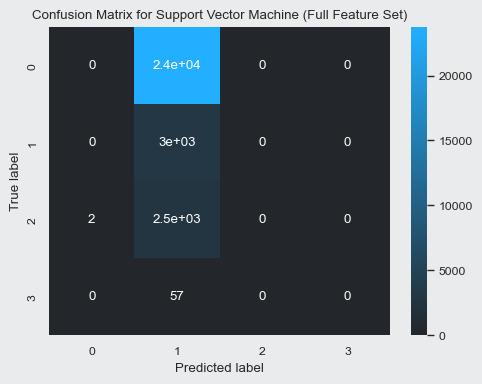

In [103]:
# Evaluate this model
svc_model_label_result = evaluate_model(
    model=best_svc_label,
    X_test=X_test_label,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, svc_model_label_result.predictions, "Support Vector Machine (Full Feature Set)")

In [104]:
# Compare with respective prototype model
_ = compare_models(svc_model_label_result, svc_hpt_label_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.207412 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.743175 --> Worsened!

Best model so far:
SVC(C=0.4, degree=10, kernel='linear', max_iter=15000, random_state=404,
    tol=1e-06)
Its score: 0.437669



-- Testing Results --
Accuracy    on Verification Data:	0.217442
Fbeta scroe on Verification Data:	0.292036

              precision    recall  f1-score   support

           0       0.62      0.15      0.24     23747
           1       0.05      0.34      0.09      3041
           2       0.77      0.69      0.73      2533
           3       0.00      0.00      0.00        57

    accuracy                           0.22     29378
   macro avg       0.36      0.30      0.26     29378
weighted avg       0.57      0.22      0.27     29378



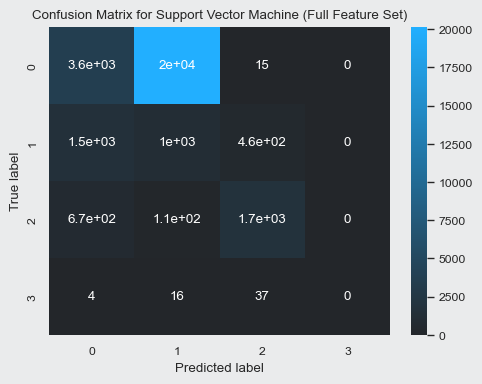

In [105]:
# Evaluate this model
svc_model_1hot_result = evaluate_model(
    model=best_svc_1hot,
    X_test=X_test_1hot,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, svc_model_1hot_result.predictions, "Support Vector Machine (Full Feature Set)")

In [106]:
# Compare with respective prototype model
_ = compare_models(svc_model_1hot_result, svc_hpt_1hot_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.050543 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.003812 --> Improvement!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.292036


In [107]:
# Compare prototype models with each other
print('\tSupport Vector Machine: Label Encoded VS One-hot Encoded')
_ = compare_models(svc_hpt_label_result, svc_hpt_1hot_result)

	Support Vector Machine: Label Encoded VS One-hot Encoded
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.196177 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.633059 --> Improvement!

Best model so far:
SVC(C=0.4, degree=10, kernel='linear', max_iter=15000, random_state=404,
    tol=1e-06) with Parameters
{'tol': 1e-06, 'kernel': 'linear', 'degree': 10, 'C': 0.4}
Its score: 0.437669


In [108]:
# Compare full models with each other
print('\tSupport Vector Machine: Label Encoded VS One-hot Encoded (Full Featureset)')
_ = compare_models(svc_model_label_result, svc_model_1hot_result)

	Support Vector Machine: Label Encoded VS One-hot Encoded (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.061778 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.113929 --> Worsened!

Best model so far:
SVC(C=1.4, kernel='linear', max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.292036


In [109]:
# Compare with previous HPT results
BEST_HPT_SUB_RESULT = compare_models(svc_hpt_label_result, BEST_HPT_SUB_RESULT)
print()
BEST_HPT_SUB_RESULT = compare_models(svc_hpt_1hot_result, BEST_HPT_SUB_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.199524 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.061951 --> Worsened!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404) with Parameters
{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 150}
Its score: 0.637194

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.395701 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.695010 --> Worsened!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404) with Parameters
{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 150}
Its score: 0.637194


In [110]:
# Track overall best model
_ = compare_models(svc_model_label_result, results(top_overall(1)[0]))
print()
_ = compare_models(svc_model_1hot_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.455472 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.798727 --> Worsened!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404)
Its score: 0.685729

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.393693 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.684798 --> Worsened!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404)
Its score: 0.685729


In [111]:
# Store the model results
add_unscaled_model('Support Vector Machine', svc_model_label_result, label_encoded=True)
add_unscaled_model('Support Vector Machine', svc_model_1hot_result, label_encoded=False)

--------------------------------------------------------------------------------

## Gradient Boost

In [112]:
from sklearn.ensemble import GradientBoostingClassifier

In [113]:
gradient_boost = GradientBoostingClassifier(random_state=404)                           # base estimator
gb_param_grid = {                                                                       # parameter grid for hyperparameter tuning
    'loss': ['log_loss', 'exponential'],
    'learning_rate': [.1, .5, 1., 1.5, 10.],
    'n_estimators': rf_param_grid['n_estimators'],
    'max_depth': rf_param_grid['max_depth'],
    'max_features': ['sqrt', 'log2'],
    'tol': lr_param_grid['tol'],
}

In [114]:
gb_model_label = RandomizedSearchCV(
    estimator=gradient_boost,
    param_distributions=gb_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer,
    n_jobs=-1,
    n_iter=15,
    random_state=404
)
gb_model_1hot = RandomizedSearchCV(
    estimator=gradient_boost,
    param_distributions=gb_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer,
    n_jobs=-1,
    n_iter=15,
    random_state=404
)

In [115]:
%time _ = gb_model_label.fit(X_training_label_sub, y_training)

CPU times: user 1min 5s, sys: 17.9 s, total: 1min 23s
Wall time: 4min 17s


In [116]:
%time _ = gb_model_1hot.fit(X_training_1hot_sub, y_training)

CPU times: user 1.18 s, sys: 342 ms, total: 1.53 s
Wall time: 2min 40s


-- Training Results --
Best Parameters:
	tol:	1e-05
	n_estimators:	100
	max_features:	sqrt
	max_depth:	20
	loss:	log_loss
	learning_rate:	0.1
Best Score:
	0.759312

-- Testing Results --
Accuracy    on Verification Data:	0.908911
Fbeta scroe on Verification Data:	0.588911

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     23747
           1       0.71      0.79      0.75      3041
           2       0.75      0.53      0.62      2533
           3       0.02      0.07      0.03        57

    accuracy                           0.91     29378
   macro avg       0.61      0.59      0.59     29378
weighted avg       0.91      0.91      0.91     29378



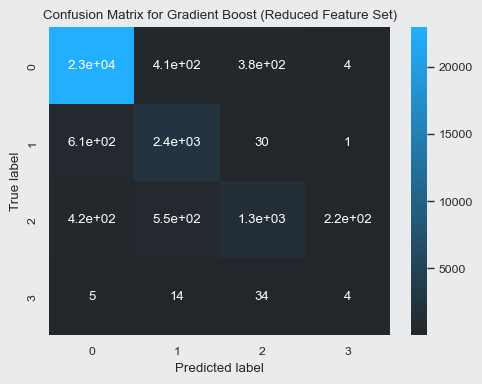

In [117]:
# Evaluate the process
gb_hpt_label_result = evaluate_hpt(
    model=gb_model_label,
    X_test=X_test_label_sub,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, gb_hpt_label_result.predictions, 'Gradient Boost (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	tol:	1e-05
	n_estimators:	5
	max_features:	log2
	max_depth:	40
	loss:	log_loss
	learning_rate:	10.0
Best Score:
	0.853020

-- Testing Results --
Accuracy    on Verification Data:	0.889850
Fbeta scroe on Verification Data:	0.647126

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     23747
           1       0.54      0.93      0.68      3041
           2       0.73      0.57      0.64      2533
           3       0.23      0.18      0.20        57

    accuracy                           0.89     29378
   macro avg       0.62      0.65      0.62     29378
weighted avg       0.92      0.89      0.90     29378



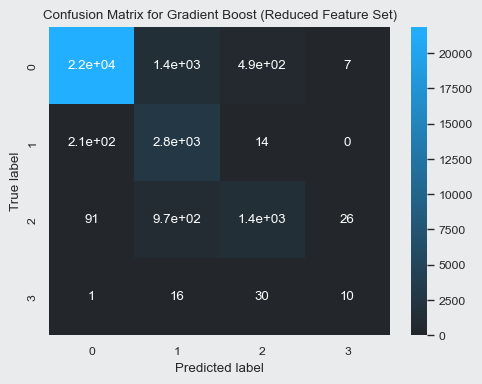

In [118]:
# Evaluate the process
gb_hpt_1hot_result = evaluate_hpt(
    model=gb_model_1hot,
    X_test=X_test_1hot_sub,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, gb_hpt_1hot_result.predictions, 'Gradient Boost (Reduced Feature Set)')

Next, let's let the best candidate of this process train on the full featureset.

In [119]:
best_gb_label = gb_model_label.best_estimator_
best_gb_1hot = gb_model_1hot.best_estimator_

In [120]:
%time _ = best_gb_label.fit(X_training_label, y_training)

CPU times: user 41.8 s, sys: 7.78 s, total: 49.5 s
Wall time: 49.3 s


In [121]:
%time _ = best_gb_1hot.fit(X_training_1hot, y_training)

CPU times: user 742 ms, sys: 229 ms, total: 971 ms
Wall time: 983 ms



-- Testing Results --
Accuracy    on Verification Data:	0.907175
Fbeta scroe on Verification Data:	0.680711

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     23747
           1       0.61      0.84      0.71      3041
           2       0.96      0.54      0.69      2533
           3       0.05      0.42      0.08        57

    accuracy                           0.91     29378
   macro avg       0.65      0.69      0.61     29378
weighted avg       0.94      0.91      0.91     29378



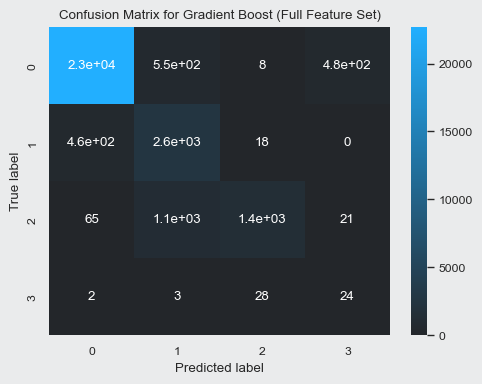

In [122]:
# Evaluate this model
gb_model_label_result = evaluate_model(
    model=best_gb_label,
    X_test=X_test_label,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, gb_model_label_result.predictions, "Gradient Boost (Full Feature Set)")

In [123]:
# Compare with respective prototype model
_ = compare_models(gb_model_label_result, gb_hpt_label_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.091800 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.001736 --> Worsened!

Best model so far:
GradientBoostingClassifier(max_depth=20, max_features='sqrt', random_state=404,
                           tol=1e-05)
Its score: 0.680711



-- Testing Results --
Accuracy    on Verification Data:	0.866805
Fbeta scroe on Verification Data:	0.717134

              precision    recall  f1-score   support

           0       0.99      0.89      0.94     23747
           1       0.50      0.91      0.65      3041
           2       0.71      0.56      0.62      2533
           3       0.07      0.54      0.13        57

    accuracy                           0.87     29378
   macro avg       0.57      0.73      0.58     29378
weighted avg       0.91      0.87      0.88     29378



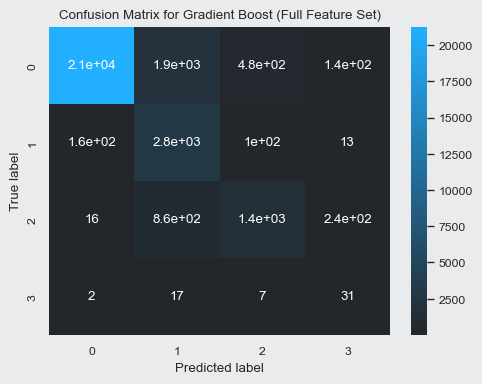

In [124]:
# Evaluate this model
gb_model_1hot_result = evaluate_model(
    model=best_gb_1hot,
    X_test=X_test_1hot,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, gb_model_1hot_result.predictions, "Gradient Boost (Full Feature Set)")

In [125]:
# Compare with respective prototype model
_ = compare_models(gb_model_1hot_result, gb_hpt_1hot_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.070008 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.023044 --> Worsened!

Best model so far:
GradientBoostingClassifier(learning_rate=10.0, max_depth=40,
                           max_features='log2', n_estimators=5,
                           random_state=404, tol=1e-05)
Its score: 0.717134


In [126]:
# Compare full models with each other
print('\tGradient Boost: Label Encoded VS One-hot Encoded')
_ = compare_models(gb_hpt_label_result, gb_hpt_1hot_result)

	Gradient Boost: Label Encoded VS One-hot Encoded
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.058214 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.019062 --> Improvement!

Best model so far:
GradientBoostingClassifier(learning_rate=10.0, max_depth=40,
                           max_features='log2', n_estimators=5,
                           random_state=404, tol=1e-05) with Parameters
{'tol': 1e-05, 'n_estimators': 5, 'max_features': 'log2', 'max_depth': 40, 'loss': 'log_loss', 'learning_rate': 10.0}
Its score: 0.647126


In [127]:
# Compare full models with each other
print('\tGradient Boost: Label Encoded VS One-hot Encoded (Full Featureset)')
_ = compare_models(gb_model_label_result, gb_model_1hot_result)

	Gradient Boost: Label Encoded VS One-hot Encoded (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.036422 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.040370 --> Improvement!

Best model so far:
GradientBoostingClassifier(learning_rate=10.0, max_depth=40,
                           max_features='log2', n_estimators=5,
                           random_state=404, tol=1e-05)
Its score: 0.717134


In [128]:
# Compare with previous HPT results
BEST_HPT_SUB_RESULT = compare_models(gb_hpt_label_result, BEST_HPT_SUB_RESULT)
print()
BEST_HPT_SUB_RESULT = compare_models(gb_hpt_1hot_result, BEST_HPT_SUB_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.048283 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000272 --> Improvement!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404) with Parameters
{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 150}
Its score: 0.637194

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.009932 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.018790 --> Worsened!

Best model so far:
GradientBoostingClassifier(learning_rate=10.0, max_depth=40,
                           max_features='log2', n_estimators=5,
                           random_state=404, tol=1e-05) with Parameters
{'tol': 1e-05, 'n_estimators': 5, 'max_features': 'log2', 'max_depth': 40, 'loss': 'log_loss', 'learning_rate': 10.0}
Its score: 0.647126


In [129]:
# Track overall best model
_ = compare_models(gb_model_label_result, results(top_overall(1)[0]))
print()
_ = compare_models(gb_model_1hot_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.005017 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.004936 --> Improvement!

Best model so far:
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       n_jobs=-1, random_state=404)
Its score: 0.685729

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.031405 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.035435 --> Worsened!

Best model so far:
GradientBoostingClassifier(learning_rate=10.0, max_depth=40,
                           max_features='log2', n_estimators=5,
                           random_state=404, tol=1e-05)
Its score: 0.717134


In [130]:
# Store the model results
add_unscaled_model('Gradient Boost', gb_model_label_result, label_encoded=True)
add_unscaled_model('Gradient Boost', gb_model_1hot_result, label_encoded=False)

--------------------------------------------------------------------------------

## Ada Boost

In [131]:
from sklearn.ensemble import AdaBoostClassifier

In [132]:
ada_boost = AdaBoostClassifier(algorithm='SAMME', random_state=404)                     # base estimator
ab_param_grid = {                                                                       # parameter grid for hyperparameter tuning
    'learning_rate': gb_param_grid['learning_rate'],
    'n_estimators': gb_param_grid['n_estimators'],
}

In [133]:
ab_model_label = GridSearchCV(
    estimator=ada_boost,
    param_grid=ab_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
ab_model_1hot = GridSearchCV(
    estimator=ada_boost,
    param_grid=ab_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)

In [134]:
%time _ = ab_model_label.fit(X_training_label_sub, y_training)

CPU times: user 4min 57s, sys: 27.1 s, total: 5min 24s
Wall time: 5min 25s


In [135]:
%time _ = ab_model_1hot.fit(X_training_1hot_sub, y_training)

CPU times: user 5min 30s, sys: 33.6 s, total: 6min 3s
Wall time: 1h 25min 51s


-- Training Results --
Best Parameters:
	learning_rate:	1.5
	n_estimators:	150
Best Score:
	0.756289

-- Testing Results --
Accuracy    on Verification Data:	0.887977
Fbeta scroe on Verification Data:	0.620793

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     23747
           1       0.59      0.82      0.68      3041
           2       0.68      0.62      0.65      2533
           3       0.14      0.12      0.13        57

    accuracy                           0.89     29378
   macro avg       0.59      0.62      0.60     29378
weighted avg       0.90      0.89      0.89     29378



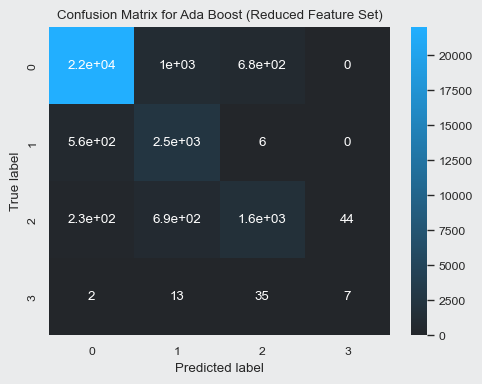

In [136]:
# Evaluate the process
ab_hpt_label_result = evaluate_hpt(
    model=ab_model_label,
    X_test=X_test_label_sub,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, ab_hpt_label_result.predictions, 'Ada Boost (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	learning_rate:	1.0
	n_estimators:	100
Best Score:
	0.756271

-- Testing Results --
Accuracy    on Verification Data:	0.876779
Fbeta scroe on Verification Data:	0.521703

              precision    recall  f1-score   support

           0       0.91      0.96      0.93     23747
           1       0.75      0.70      0.72      3041
           2       0.69      0.32      0.44      2533
           3       0.02      0.11      0.04        57

    accuracy                           0.88     29378
   macro avg       0.59      0.52      0.53     29378
weighted avg       0.87      0.88      0.87     29378



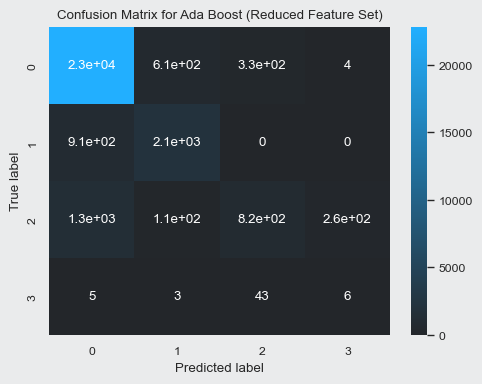

In [137]:
# Evaluate the process
ab_hpt_1hot_result = evaluate_hpt(
    model=ab_model_1hot,
    X_test=X_test_1hot_sub,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, ab_hpt_1hot_result.predictions, 'Ada Boost (Reduced Feature Set)')

Next, let's let the best candidate of this process train on the full featureset.

In [138]:
best_ab_label = ab_model_label.best_estimator_
best_ab_1hot = ab_model_1hot.best_estimator_

In [139]:
%time _ = best_ab_label.fit(X_training_label, y_training)

CPU times: user 12.5 s, sys: 1.11 s, total: 13.6 s
Wall time: 13.2 s


In [140]:
%time _ = best_ab_1hot.fit(X_training_1hot, y_training)

CPU times: user 13.3 s, sys: 1.65 s, total: 14.9 s
Wall time: 17min 45s



-- Testing Results --
Accuracy    on Verification Data:	0.748213
Fbeta scroe on Verification Data:	0.565746

              precision    recall  f1-score   support

           0       0.99      0.77      0.86     23747
           1       0.29      0.94      0.44      3041
           2       0.90      0.34      0.49      2533
           3       0.28      0.23      0.25        57

    accuracy                           0.75     29378
   macro avg       0.61      0.57      0.51     29378
weighted avg       0.91      0.75      0.79     29378



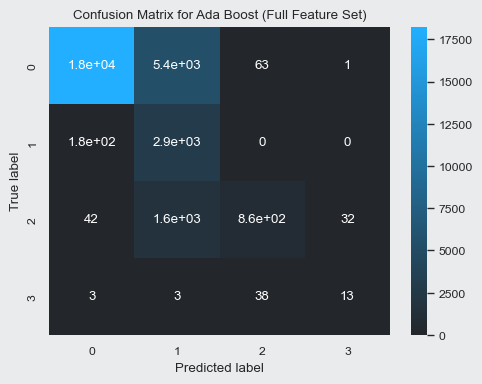

In [141]:
# Evaluate this model
ab_model_label_result = evaluate_model(
    model=best_ab_label,
    X_test=X_test_label,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, ab_model_label_result.predictions, "Ada Boost (Full Feature Set)")

In [142]:
# Compare with respective prototype model
_ = compare_models(ab_model_label_result, ab_hpt_label_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.055047 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.139764 --> Worsened!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', learning_rate=1.5, n_estimators=150,
                   random_state=404)
Its score: 0.620793



-- Testing Results --
Accuracy    on Verification Data:	0.920144
Fbeta scroe on Verification Data:	0.681215

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     23747
           1       0.63      0.93      0.75      3041
           2       0.82      0.69      0.75      2533
           3       0.26      0.16      0.20        57

    accuracy                           0.92     29378
   macro avg       0.67      0.68      0.67     29378
weighted avg       0.94      0.92      0.92     29378



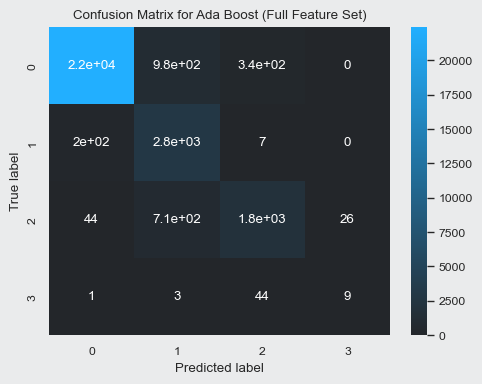

In [143]:
# Evaluate this model
ab_model_1hot_result = evaluate_model(
    model=best_ab_1hot,
    X_test=X_test_1hot,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, ab_model_1hot_result.predictions, "Ada Boost (Full Feature Set)")

In [144]:
# Compare with respective prototype model
_ = compare_models(ab_model_1hot_result, ab_hpt_1hot_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.159512 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.043366 --> Improvement!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', n_estimators=100, random_state=404)
Its score: 0.681215


In [145]:
# Compare prototype models with each other
print('\tAda Boost : Label Encoded VS One-hot Encoded')
_ = compare_models(ab_hpt_label_result, ab_hpt_1hot_result)

	Ada Boost : Label Encoded VS One-hot Encoded
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.099089 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.011199 --> Improvement!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', learning_rate=1.5, n_estimators=150,
                   random_state=404) with Parameters
{'learning_rate': 1.5, 'n_estimators': 150}
Its score: 0.620793


In [146]:
# Compare full models with each other
print('\tAda Boost: Label Encoded VS One-hot Encoded (Full Featureset)')
_ = compare_models(ab_model_label_result, ab_model_1hot_result)

	Ada Boost: Label Encoded VS One-hot Encoded (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.115470 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.171931 --> Worsened!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', n_estimators=100, random_state=404)
Its score: 0.681215


In [147]:
# Compare with previous HPT results
BEST_HPT_SUB_RESULT = compare_models(ab_hpt_label_result, BEST_HPT_SUB_RESULT)
print()
BEST_HPT_SUB_RESULT = compare_models(ab_hpt_1hot_result, BEST_HPT_SUB_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.026333 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.001872 --> Worsened!

Best model so far:
GradientBoostingClassifier(learning_rate=10.0, max_depth=40,
                           max_features='log2', n_estimators=5,
                           random_state=404, tol=1e-05) with Parameters
{'tol': 1e-05, 'n_estimators': 5, 'max_features': 'log2', 'max_depth': 40, 'loss': 'log_loss', 'learning_rate': 10.0}
Its score: 0.647126

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.125422 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.013071 --> Worsened!

Best model so far:
GradientBoostingClassifier(learning_rate=10.0, max_depth=40,
                           max_features='log2', n_estimators=5,
                           random_state=404, tol=1e-05) with Parameters
{'tol': 1e-05, 'n_estimators': 5, 'max_features': 'log2', 'max_depth': 40, 'loss': 'log_loss', 'learning_rate': 10.0}

In [148]:
# Track overall best model
_ = compare_models(ab_model_label_result, results(top_overall(1)[0]))
print()
_ = compare_models(ab_model_1hot_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.151388 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.118592 --> Worsened!

Best model so far:
GradientBoostingClassifier(learning_rate=10.0, max_depth=40,
                           max_features='log2', n_estimators=5,
                           random_state=404, tol=1e-05)
Its score: 0.717134

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.035918 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.053339 --> Improvement!

Best model so far:
GradientBoostingClassifier(learning_rate=10.0, max_depth=40,
                           max_features='log2', n_estimators=5,
                           random_state=404, tol=1e-05)
Its score: 0.717134


In [149]:
# Store the model results
add_unscaled_model('Ada Boost', ab_model_label_result, label_encoded=True)
add_unscaled_model('Ada Boost', ab_model_1hot_result, label_encoded=False)

--------------------------------------------------------------------------------

## Artificial Neural Network

In [150]:
from sklearn.neural_network import MLPClassifier

In [151]:
neural_network = MLPClassifier(                                                             # base estimator
    solver='adam',
    learning_rate='constant',
    early_stopping=True,
    random_state=404
)
nn_param_grid = {                                                                           # parameter grid for hyperparameter tuning
    'hidden_layer_sizes': [(128,), (128, 128), (64, 64, 32), (124, 64, 32), (64, 64, 64, 32), (64, 32, 16)],
    'activation': ['relu', 'logistic', 'tanh'],
    'alpha': [1.e-4, 1.e-3, 1.e-2],
    'learning_rate_init': ab_param_grid['learning_rate'],
    'tol': gb_param_grid['tol'],
}

In [152]:
nn_model_label = RandomizedSearchCV(
    estimator=neural_network,
    param_distributions=nn_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer,
	n_jobs=-1,
	n_iter=15,
	random_state=404
)
nn_model_1hot = RandomizedSearchCV(
    estimator=neural_network,
    param_distributions=nn_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer,
	n_jobs=-1,
	n_iter=15,
	random_state=404
)

In [153]:
%time _ = nn_model_label.fit(X_training_label_sub, y_training)

CPU times: user 1min 31s, sys: 1.64 s, total: 1min 33s
Wall time: 1h 24min 56s


In [154]:
%time _ = nn_model_1hot.fit(X_training_1hot_sub, y_training)

CPU times: user 3min 52s, sys: 4.11 s, total: 3min 56s
Wall time: 18min 11s


-- Training Results --
Best Parameters:
	tol:	0.0001
	learning_rate_init:	0.1
	hidden_layer_sizes:	(128,)
	alpha:	0.0001
	activation:	tanh
Best Score:
	0.499893

-- Testing Results --
Accuracy    on Verification Data:	0.785860
Fbeta scroe on Verification Data:	0.274751

              precision    recall  f1-score   support

           0       0.84      0.95      0.89     23747
           1       0.16      0.11      0.13      3041
           2       0.23      0.04      0.07      2533
           3       0.00      0.00      0.00        57

    accuracy                           0.79     29378
   macro avg       0.31      0.27      0.27     29378
weighted avg       0.72      0.79      0.74     29378



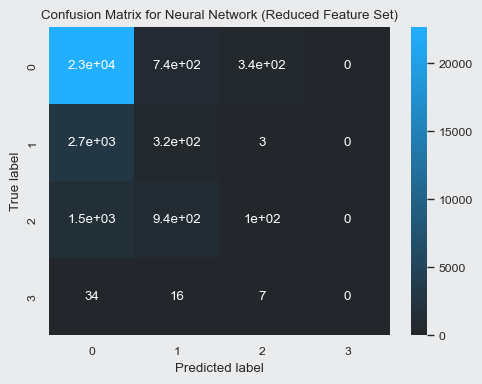

In [155]:
# Evaluate the process
nn_hpt_label_result = evaluate_hpt(
    model=nn_model_label,
    X_test=X_test_label_sub,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, nn_hpt_label_result.predictions, 'Neural Network (Reduced Feature Set)')

-- Training Results --
Best Parameters:
	tol:	0.0001
	learning_rate_init:	0.1
	hidden_layer_sizes:	(128,)
	alpha:	0.0001
	activation:	tanh
Best Score:
	0.480987

-- Testing Results --
Accuracy    on Verification Data:	0.822895
Fbeta scroe on Verification Data:	0.450569

              precision    recall  f1-score   support

           0       0.97      0.90      0.94     23747
           1       0.35      0.79      0.49      3041
           2       0.63      0.12      0.19      2533
           3       0.00      0.00      0.00        57

    accuracy                           0.82     29378
   macro avg       0.49      0.45      0.40     29378
weighted avg       0.88      0.82      0.82     29378



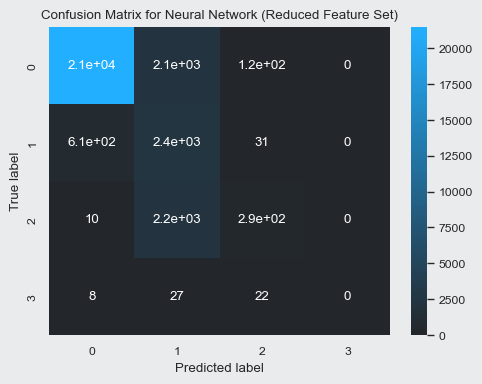

In [156]:
# Evaluate the process
nn_hpt_1hot_result = evaluate_hpt(
    model=nn_model_1hot,
    X_test=X_test_1hot_sub,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, nn_hpt_1hot_result.predictions, 'Neural Network (Reduced Feature Set)')

Next, let's let the best candidate of this process train on the full featureset.

In [157]:
best_nn_label = nn_model_label.best_estimator_
best_nn_1hot = nn_model_1hot.best_estimator_

In [158]:
%time _ = best_nn_label.fit(X_training_label, y_training)

CPU times: user 2min 7s, sys: 1.7 s, total: 2min 9s
Wall time: 16.9 s


In [159]:
%time _ = best_nn_1hot.fit(X_training_1hot, y_training)

CPU times: user 3min 4s, sys: 2.92 s, total: 3min 7s
Wall time: 24.4 s



-- Testing Results --
Accuracy    on Verification Data:	0.836136
Fbeta scroe on Verification Data:	0.563864

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     23747
           1       0.43      0.51      0.47      3041
           2       0.59      0.03      0.07      2533
           3       0.06      0.86      0.10        57

    accuracy                           0.84     29378
   macro avg       0.50      0.59      0.40     29378
weighted avg       0.84      0.84      0.82     29378



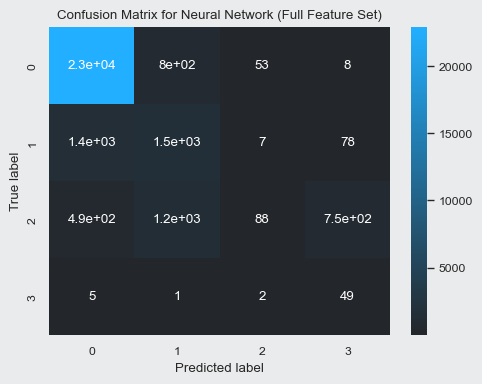

In [160]:
# Evaluate this model
nn_model_label_result = evaluate_model(
    model=best_nn_label,
    X_test=X_test_label,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, nn_model_label_result.predictions, "Neural Network (Full Feature Set)")

In [161]:
# Compare with respective prototype model
_ = compare_models(nn_model_label_result, nn_hpt_label_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.289114 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.050276 --> Improvement!

Best model so far:
MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=(128,),
              learning_rate_init=0.1, random_state=404)
Its score: 0.563864



-- Testing Results --
Accuracy    on Verification Data:	0.834638
Fbeta scroe on Verification Data:	0.510486

              precision    recall  f1-score   support

           0       0.96      0.92      0.94     23747
           1       0.40      0.71      0.51      3041
           2       0.47      0.25      0.32      2533
           3       0.43      0.18      0.25        57

    accuracy                           0.83     29378
   macro avg       0.57      0.51      0.51     29378
weighted avg       0.86      0.83      0.84     29378



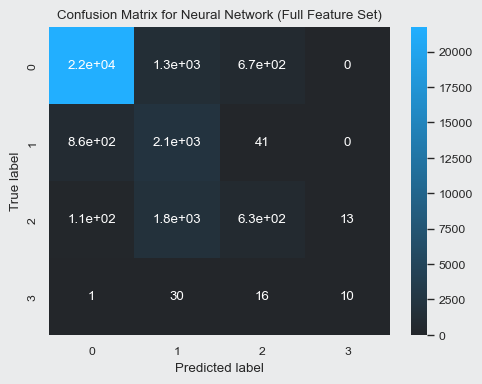

In [162]:
# Evaluate this model
nn_model_1hot_result = evaluate_model(
    model=best_nn_1hot,
    X_test=X_test_1hot,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)
# Display the confusion matrix
confusion_matrix(y_true, nn_model_1hot_result.predictions, "Neural Network (Full Feature Set)")

In [163]:
# Compare with respective prototype model
_ = compare_models(nn_model_1hot_result, nn_hpt_1hot_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.059916 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.011743 --> Improvement!

Best model so far:
MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=(128,),
              learning_rate_init=0.1, random_state=404)
Its score: 0.510486


In [164]:
# Compare prototype models with each other
print('\tNeural Network: Label Encoded VS One-hot Encoded')
_ = compare_models(nn_hpt_label_result, nn_hpt_1hot_result)

	Neural Network: Label Encoded VS One-hot Encoded
-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.175819 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.037035 --> Worsened!

Best model so far:
MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=(128,),
              learning_rate_init=0.1, random_state=404) with Parameters
{'tol': 0.0001, 'learning_rate_init': 0.1, 'hidden_layer_sizes': (128,), 'alpha': 0.0001, 'activation': 'tanh'}
Its score: 0.450569


In [165]:
# Compare full models with each other
print('\tNeural Network: Label Encoded VS One-hot Encoded (Full Featureset)')
_ = compare_models(nn_model_label_result, nn_model_1hot_result)

	Neural Network: Label Encoded VS One-hot Encoded (Full Featureset)
-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.053378 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.001498 --> Improvement!

Best model so far:
MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=(128,),
              learning_rate_init=0.1, random_state=404)
Its score: 0.563864


In [166]:
# Compare with previous HPT results
BEST_HPT_SUB_RESULT = compare_models(nn_hpt_label_result, BEST_HPT_SUB_RESULT)
print()
BEST_HPT_SUB_RESULT = compare_models(nn_hpt_1hot_result, BEST_HPT_SUB_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.372375 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.103989 --> Worsened!

Best model so far:
GradientBoostingClassifier(learning_rate=10.0, max_depth=40,
                           max_features='log2', n_estimators=5,
                           random_state=404, tol=1e-05) with Parameters
{'tol': 1e-05, 'n_estimators': 5, 'max_features': 'log2', 'max_depth': 40, 'loss': 'log_loss', 'learning_rate': 10.0}
Its score: 0.647126

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.196556 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.066955 --> Worsened!

Best model so far:
GradientBoostingClassifier(learning_rate=10.0, max_depth=40,
                           max_features='log2', n_estimators=5,
                           random_state=404, tol=1e-05) with Parameters
{'tol': 1e-05, 'n_estimators': 5, 'max_features': 'log2', 'max_depth': 40, 'loss': 'log_loss', 'learning_rate': 10.0}

In [167]:
# Track overall best model
_ = compare_models(nn_model_label_result, results(top_overall(1)[0]))
print()
_ = compare_models(nn_model_1hot_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.153270 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.030669 --> Worsened!

Best model so far:
GradientBoostingClassifier(learning_rate=10.0, max_depth=40,
                           max_features='log2', n_estimators=5,
                           random_state=404, tol=1e-05)
Its score: 0.717134

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.206648 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.032167 --> Worsened!

Best model so far:
GradientBoostingClassifier(learning_rate=10.0, max_depth=40,
                           max_features='log2', n_estimators=5,
                           random_state=404, tol=1e-05)
Its score: 0.717134


In [168]:
# Store the model results
add_unscaled_model('Neural Network', nn_model_label_result, label_encoded=True)
add_unscaled_model('Neural Network', nn_model_1hot_result, label_encoded=False)

--------------------------------------------------------------------------------

## Voting Classification

First, let's have a look at our best models.

In [170]:
num_models = 4
best_label_models = top_unscaled(num_models, label_encoded=True)    # top n models on label-encoded data
best_1hot_models = top_unscaled(num_models, label_encoded=False)    # top n models on one-hot encoded data

# For confirmation, print the top n for the scaled case:
list(map(name, best_label_models))

['Gradient Boost', 'Random Forest', 'KNN', 'Ada Boost']

In [171]:
list(map(name, best_1hot_models))

['Gradient Boost', 'Random Forest', 'Ada Boost', 'KNN']

In [172]:
from sklearn.ensemble import VotingClassifier

In [173]:
# Construct the voting classifier with the best models
def make_voting_classifier(models):
    return VotingClassifier(
        list(
            map(
                lambda model: (name(model), results(model).model),
                models
            )
        ),
        voting='soft',
        n_jobs=-1
    )
compound = make_voting_classifier(best_label_models)

In [176]:
# Train the classifiers

%time _ = compound.fit(X_training_label, y_training)

CPU times: user 159 ms, sys: 382 ms, total: 540 ms
Wall time: 1min 5s


In [182]:
# Evaluate the result
compound_result = evaluate_model(
    model=compound,
    X_test=X_test_label,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE,
    display_false_negatives=False
)


-- Testing Results --
Accuracy    on Verification Data:	0.894036
Fbeta scroe on Verification Data:	0.675425

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     23747
           1       0.50      0.90      0.65      3041
           2       0.96      0.34      0.50      2533
           3       0.49      0.51      0.50        57

    accuracy                           0.89     29378
   macro avg       0.73      0.68      0.65     29378
weighted avg       0.93      0.89      0.89     29378



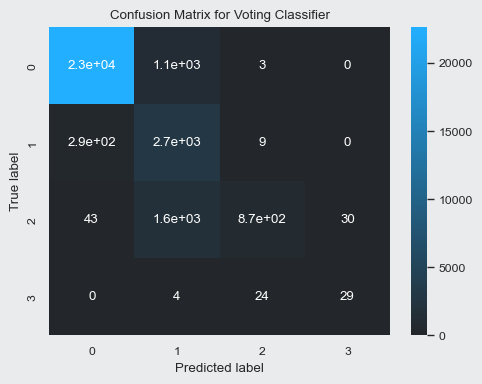

In [181]:
# Display the confusion matrix
confusion_matrix(y_true, compound_result.predictions, "Voting Classifier")

--------------------------------------------------------------------------------

<!--
To next notebook: [Network Traffic ML Part 2](./network-traffic-ml-part2.ipynb)
-->